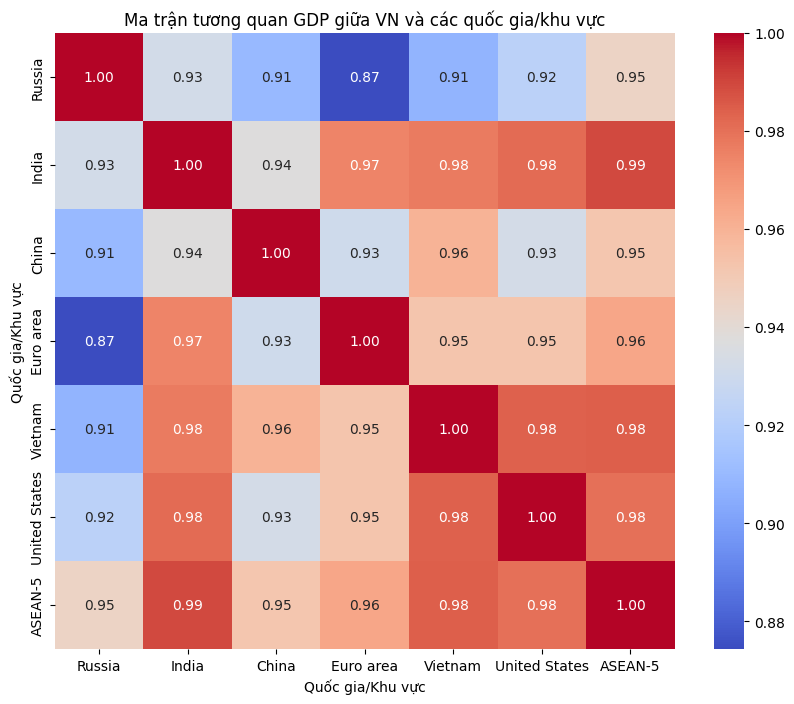

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Tên các file CSV chứa dữ liệu GDP
file_paths = [
    'Russia_GDP_10yrs.csv',
    'India_GDP_10yrs.csv',
    'China_GDP_10yrs.csv',
    'Euro_GDP_10yrs.csv',
    'VN_GDP_10yrs.csv',
    'USA_GDP_10yrs.csv',
    'ASEAN5_GDP_10yrs.csv'
]

# Dictionary để lưu trữ dữ liệu GDP của từng quốc gia/khu vực
gdp_data = {}

# Đọc dữ liệu từ từng file CSV và tiền xử lý
for file_path in file_paths:
    try:
        df = pd.read_csv(file_path)
        country_name = df.iloc[0, 0] # Lấy tên quốc gia hoặc khu vực từ cột đầu tiên, dòng đầu tiên
        if file_path == 'Euro_GDP_10yrs.csv' or file_path == 'ASEAN5_GDP_10yrs.csv':
            country_name = df.iloc[0, 0] # For 'Country Group Name' files
        else:
            country_name = df.iloc[0, 0] # For 'Country' files

        # Lấy dữ liệu GDP từ cột 2015 đến 2024 và chuyển đổi sang số
        gdp_values = df.iloc[0, 5:15].values.tolist()
        gdp_values_numeric = []
        for val in gdp_values:
            if isinstance(val, str):
                val_cleaned = val.replace(",", "")
            else:
                val_cleaned = str(val)
            try:
                gdp_values_numeric.append(float(val_cleaned))
            except ValueError:
                gdp_values_numeric.append(None) # Handle cases where conversion fails

        gdp_data[country_name] = pd.Series(gdp_values_numeric, index=range(2015, 2025))

    except FileNotFoundError:
        print(f"Không tìm thấy file: {file_path}")
        continue
    except Exception as e:
        print(f"Lỗi khi xử lý file {file_path}: {e}")
        continue

# Tạo DataFrame từ dữ liệu GDP
gdp_df = pd.DataFrame(gdp_data)

# Tính ma trận tương quan
correlation_matrix = gdp_df.corr()

# Trực quan hóa ma trận tương quan bằng Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Ma trận tương quan GDP giữa VN và các quốc gia/khu vực')
plt.xlabel('Quốc gia/Khu vực')
plt.ylabel('Quốc gia/Khu vực')
plt.show()

In [12]:
import pandas as pd
import warnings
warnings.simplefilter("ignore")
from statsmodels.tsa.stattools import grangercausalitytests

# Tên các file CSV chứa dữ liệu GDP
file_paths = [
    'Russia_GDP_10yrs.csv',
    'India_GDP_10yrs.csv',
    'China_GDP_10yrs.csv',
    'Euro_GDP_10yrs.csv',
    'VN_GDP_10yrs.csv',
    'USA_GDP_10yrs.csv',
    'ASEAN5_GDP_10yrs.csv'
]

# Dictionary để lưu trữ dữ liệu GDP của từng quốc gia/khu vực
gdp_data = {}

# Đọc dữ liệu từ từng file CSV và tiền xử lý
for file_path in file_paths:
    try:
        df = pd.read_csv(file_path)
        country_name = df.iloc[0, 0] # Lấy tên quốc gia hoặc khu vực từ cột đầu tiên, dòng đầu tiên
        if file_path == 'Euro_GDP_10yrs.csv' or file_path == 'ASEAN5_GDP_10yrs.csv':
            country_name = df.iloc[0, 0] # For 'Country Group Name' files
        else:
            country_name = df.iloc[0, 0] # For 'Country' files

        # Lấy dữ liệu GDP từ cột 2015 đến 2024 và chuyển đổi sang số
        gdp_values = df.iloc[0, 5:15].values.tolist()
        gdp_values_numeric = []
        for val in gdp_values:
            if isinstance(val, str):
                val_cleaned = val.replace(",", "")
            else:
                val_cleaned = str(val)
            try:
                gdp_values_numeric.append(float(val_cleaned))
            except ValueError:
                gdp_values_numeric.append(None) # Handle cases where conversion fails

        gdp_data[country_name] = pd.Series(gdp_values_numeric, index=range(2015, 2025))

    except FileNotFoundError:
        print(f"Không tìm thấy file: {file_path}")
        continue
    except Exception as e:
        print(f"Lỗi khi xử lý file {file_path}: {e}")
        continue

# Tạo DataFrame từ dữ liệu GDP
gdp_df = pd.DataFrame(gdp_data)

# Phân tích quan hệ nhân quả Granger giữa GDP VN và các nước khác
vn_gdp = gdp_df['Vietnam'].dropna() # Đảm bảo không có giá trị NaN và là Series
countries = [col for col in gdp_df.columns if col != 'Vietnam']

maxlag = 2 # Chọn số lag tối đa cho kiểm định Granger (ví dụ: 2 năm)
test_result_dict = {}

for country in countries:
    country_gdp = gdp_df[country].dropna()
    # Đảm bảo cả hai series có cùng độ dài và không có giá trị NaN tại các vị trí tương ứng
    common_index = vn_gdp.index.intersection(country_gdp.index)
    if len(common_index) < 2: # Cần ít nhất 2 điểm dữ liệu chung để kiểm định Granger
        print(f"Không đủ dữ liệu chung giữa GDP VN và {country} để kiểm định Granger.")
        continue

    vn_gdp_common = vn_gdp[common_index]
    country_gdp_common = country_gdp[common_index]

    # Tạo DataFrame chung cho kiểm định Granger
    granger_data = pd.DataFrame({'VN_GDP': vn_gdp_common, country: country_gdp_common})

    print(f"\nKiểm định quan hệ nhân quả Granger giữa GDP VN và {country}:")

    # Kiểm định xem GDP của nước khác có nhân quả Granger đến GDP VN không
    test_result_country_to_vn = grangercausalitytests(granger_data[['VN_GDP', country]], maxlag=maxlag, verbose=False)
    p_values_country_to_vn = [round(test_result_country_to_vn[i+1][0]['ssr_ftest'][1], 3) for i in range(maxlag)]
    min_p_value_country_to_vn = min(p_values_country_to_vn)
    print(f"- Null hypothesis: GDP {country} KHÔNG nhân quả Granger đến GDP VN.")
    print(f"  P-values (lags 1-{maxlag}): {p_values_country_to_vn}")
    if min_p_value_country_to_vn < 0.05:
        print(f"  => Bác bỏ giả thuyết Null (p-value nhỏ nhất = {min_p_value_country_to_vn} < 0.05). Có thể có quan hệ nhân quả Granger từ GDP {country} đến GDP VN.")
    else:
        print(f"  => Không bác bỏ giả thuyết Null (p-value nhỏ nhất = {min_p_value_country_to_vn} >= 0.05). Chưa có đủ bằng chứng về quan hệ nhân quả Granger từ GDP {country} đến GDP VN.")

    # Kiểm định xem GDP VN có nhân quả Granger đến GDP của nước khác không
    test_result_vn_to_country = grangercausalitytests(granger_data[[country, 'VN_GDP']], maxlag=maxlag, verbose=False)
    p_values_vn_to_country = [round(test_result_vn_to_country[i+1][0]['ssr_ftest'][1], 3) for i in range(maxlag)]
    min_p_value_vn_to_country = min(p_values_vn_to_country)

    print(f"- Null hypothesis: GDP VN KHÔNG nhân quả Granger đến GDP {country}.")
    print(f"  P-values (lags 1-{maxlag}): {p_values_vn_to_country}")

    if min_p_value_vn_to_country < 0.05:
        print(f"  => Bác bỏ giả thuyết Null (p-value nhỏ nhất = {min_p_value_vn_to_country} < 0.05). Có thể có quan hệ nhân quả Granger từ GDP VN đến GDP {country}.")
    else:
        print(f"  => Không bác bỏ giả thuyết Null (p-value nhỏ nhất = {min_p_value_vn_to_country} >= 0.05). Chưa có đủ bằng chứng về quan hệ nhân quả Granger từ GDP VN đến GDP {country}.")


print("\nLưu ý quan trọng:")
print("- Phân tích này sử dụng kiểm định nhân quả Granger, KHÔNG chứng minh quan hệ nhân quả thực sự mà chỉ xác định tính TIÊN ĐOÁN.")
print("- Kết quả Granger causality rất nhạy cảm với số lượng lags chọn, cần được xem xét trong bối cảnh kinh tế và có thể cần kiểm định với số lags khác nhau.")
print("- Dữ liệu GDP 10 năm có thể là ngắn để xác định quan hệ nhân quả Granger một cách chắc chắn. Cần dữ liệu dài hơn và các yếu tố kinh tế khác để có kết luận mạnh mẽ hơn.")


Kiểm định quan hệ nhân quả Granger giữa GDP VN và Russia:
- Null hypothesis: GDP Russia KHÔNG nhân quả Granger đến GDP VN.
  P-values (lags 1-2): [0.833, 0.37]
  => Không bác bỏ giả thuyết Null (p-value nhỏ nhất = 0.37 >= 0.05). Chưa có đủ bằng chứng về quan hệ nhân quả Granger từ GDP Russia đến GDP VN.
- Null hypothesis: GDP VN KHÔNG nhân quả Granger đến GDP Russia.
  P-values (lags 1-2): [0.072, 0.074]
  => Không bác bỏ giả thuyết Null (p-value nhỏ nhất = 0.072 >= 0.05). Chưa có đủ bằng chứng về quan hệ nhân quả Granger từ GDP VN đến GDP Russia.

Kiểm định quan hệ nhân quả Granger giữa GDP VN và India:
- Null hypothesis: GDP India KHÔNG nhân quả Granger đến GDP VN.
  P-values (lags 1-2): [0.222, 0.295]
  => Không bác bỏ giả thuyết Null (p-value nhỏ nhất = 0.222 >= 0.05). Chưa có đủ bằng chứng về quan hệ nhân quả Granger từ GDP India đến GDP VN.
- Null hypothesis: GDP VN KHÔNG nhân quả Granger đến GDP India.
  P-values (lags 1-2): [0.133, 0.405]
  => Không bác bỏ giả thuyết Null (p-v

In [11]:
import pandas as pd
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt

# Tên các file CSV chứa dữ liệu GDP
file_paths = [
    'Russia_GDP_10yrs.csv',
    'India_GDP_10yrs.csv',
    'China_GDP_10yrs.csv',
    'Euro_GDP_10yrs.csv',
    'VN_GDP_10yrs.csv',
    'USA_GDP_10yrs.csv',
    'ASEAN5_GDP_10yrs.csv'
]

# Dictionary để lưu trữ dữ liệu GDP của từng quốc gia/khu vực
gdp_data = {}

# Đọc dữ liệu từ từng file CSV và tiền xử lý
for file_path in file_paths:
    try:
        df = pd.read_csv(file_path)
        # Xác định tên cột chứa tên quốc gia/khu vực
        if 'Country Group Name' in df.columns:
            country_name_col = 'Country Group Name'
        else:
            country_name_col = 'Country'

        country_name = df.iloc[0, df.columns.get_loc(country_name_col)]  # Lấy tên từ cột thích hợp

        # Lấy dữ liệu GDP từ cột 2015 đến 2024 và chuyển đổi sang số
        gdp_values = df.iloc[0, 5:15].astype(str).str.replace(",", "", regex=True)  # Loại bỏ dấu phẩy
        gdp_values_numeric = pd.to_numeric(gdp_values, errors='coerce')  # Chuyển đổi sang số
        
        # Lưu vào dictionary
        gdp_data[country_name] = pd.Series(gdp_values_numeric.values, index=range(2015, 2025))

    except FileNotFoundError:
        print(f"Không tìm thấy file: {file_path}")
        continue
    except Exception as e:
        print(f"Lỗi khi xử lý file {file_path}: {e}")
        continue

# Tạo DataFrame từ dữ liệu GDP
gdp_df = pd.DataFrame(gdp_data)

# 🔹 Kiểm tra kiểu dữ liệu trước khi đưa vào mô hình
print("\n📌 Kiểm tra kiểu dữ liệu của DataFrame trước khi xử lý:")
print(gdp_df.dtypes)

# Chuyển toàn bộ dữ liệu về dạng số
gdp_df_cleaned = gdp_df.apply(pd.to_numeric, errors='coerce')

# Loại bỏ các cột có giá trị NaN hoàn toàn
gdp_df_cleaned = gdp_df_cleaned.dropna(axis=1)

# 🔹 Kiểm tra dữ liệu sau khi làm sạch
print("\n📌 DataFrame sau khi chuyển đổi và loại bỏ NaN:")
print(gdp_df_cleaned.dtypes)
print(gdp_df_cleaned.head())

if gdp_df_cleaned.shape[1] < 2:  # VAR cần ít nhất 2 biến
    print("Không đủ dữ liệu để thực hiện phân tích VAR sau khi loại bỏ cột NaN.")
else:
    # Chọn lag order bằng AIC
    model = VAR(gdp_df_cleaned)

    try:
        lag_order_aic = model.select_order('aic')
        print(f"Lag order được chọn theo AIC: {lag_order_aic.aic_min_order}")

        # Fit VAR model với lag order được chọn bởi AIC
        fitted_model = model.fit(lag_order_aic.aic_min_order)

        print("\n--- Kết quả mô hình VAR ---")
        print(fitted_model.summary())

        # Phân tích Impulse Response Functions (IRF)
        irf = fitted_model.irf(periods=10)  # Phân tích IRF trong 10 kỳ
        plt.figure(figsize=(12, 8))
        irf.plot(orth=False)  # orth=False để xem IRF thông thường, orth=True cho Orthogonal IRF
        plt.suptitle('Impulse Response Functions (IRF)', fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.96])  # Điều chỉnh layout để không bị chồng lấp tiêu đề
        plt.show()

        # Phân tích Forecast Error Variance Decomposition (FEVD)
        fevd = fitted_model.fevd(periods=10)  # Phân tích FEVD trong 10 kỳ
        plt.figure(figsize=(12, 8))
        fevd.plot()
        plt.suptitle('Forecast Error Variance Decomposition (FEVD)', fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.96])  # Điều chỉnh layout để không bị chồng lấp tiêu đề
        plt.show()

    except Exception as e:
        print(f"Lỗi khi chạy mô hình VAR: {e}")



📌 Kiểm tra kiểu dữ liệu của DataFrame trước khi xử lý:
Russia           float64
India            float64
China            float64
Euro area        float64
Vietnam          float64
United States    float64
ASEAN-5          float64
dtype: object

📌 DataFrame sau khi chuyển đổi và loại bỏ NaN:
Russia           float64
India            float64
China            float64
Euro area        float64
Vietnam          float64
United States    float64
ASEAN-5          float64
dtype: object
       Russia    India     China  Euro area  Vietnam  United States  ASEAN-5
2015  1356.70  2103.59  11113.51   11817.52  236.795       18295.00  2177.84
2016  1280.65  2294.80  11226.90   12108.59  252.146       18804.90  2284.29
2017  1575.14  2651.47  12265.33   12825.31  277.071       19612.10  2462.80
2018  1653.01  2702.93  13841.81   13861.87  304.470       20656.53  2631.34
2019  1695.72  2835.61  14340.60   13572.91  331.818       21539.98  2781.88
Lỗi khi chạy mô hình VAR: '>' not supported between inst